# Style transfer using GAN


In [78]:
import numpy as np
import os
from os import listdir
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
% matplotlib inline
import tensorflow as tf
from numpy import asarray
from keras.preprocessing.image import img_to_array


##Data preparation (10%)	


In [79]:
def load_images(path, size=(256,256)):
    DL = list()
    for FN in listdir(path):     
        PX = load_img(path + FN, target_size=size)
        # convert to numpy array
        PX = img_to_array(PX)
        # store the data
        DL.append(PX)
    return asarray(DL)

In [80]:
#!unzip dataset.zip

In [81]:
tr1_data = load_images('dataset/Tr1/TrainT1/') 
tr1_data = tf.image.rgb_to_grayscale(tr1_data) 
tr2_data = load_images('dataset/Tr2/TrainT2/') 
tr2_data = tf.image.rgb_to_grayscale(tr2_data) 
tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))


## Data processing (15%)	


In [84]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [85]:
# normalizing the images to [-1, 1]
def normalization(image):
    image =  tf.cast(image, tf.float32)
    image = (image / 127.5)
    image = image - 1
    return image

In [86]:
def preprocess(image):
    image = tf.image.random_flip_left_right(image)
    image = normalization(image)   
    return image

In [87]:
# process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2.map(preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

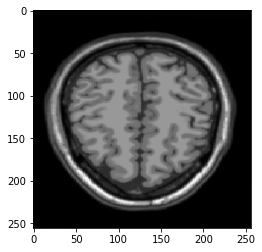

In [88]:
s_tr1 = next(iter(tr1))
plt.imshow(s_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

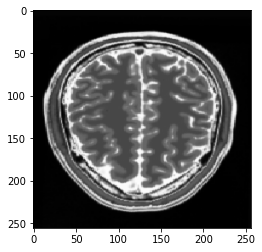

In [89]:
s_tr2 = next(iter(tr2))
plt.imshow(s_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building(35%)	


In [90]:
class IN(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(IN, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',shape=input_shape[-1:],initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(IN())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(IN())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [91]:
def unet_generator():
   
    DS = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),  
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(512, 4),  
    ]
                 
    US = [
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4),  
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
               ] 
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    #Downsampling 
    sk = []
    for down in DS:
        x = down(x)
        sk.append(x)
    sk = reversed(sk[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(US, sk):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [92]:
generator_g = unet_generator() #initialize the generator
generator_f = unet_generator() #initialize the generator

In [93]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    D1 = downsample(64, 4,  False)(x)  
    D2 = downsample(128, 4)(D1)     
    D3 = downsample(256, 4)(D2)     
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(D3) 
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) 
    norm1 = IN()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
  
    return tf.keras.Model(inputs=inp, outputs=last) 

In [94]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

In [95]:
LAMBDA = 9
# Using Binarycross entropy with logits true
loss_BinaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
    real_loss = loss_BinaryCrossentropy(tf.ones_like(real), real) 
    generated_loss = loss_BinaryCrossentropy(tf.zeros_like(generated), generated) 
    total_disc_loss = real_loss + generated_loss 
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_BinaryCrossentropy(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [96]:
# Optimizer with learning rate 0.0001 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [97]:
EPOCHS = 2

In [98]:
checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)


In [99]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [100]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
    
        fake_y = generator_g(real_x, training=True)  
        cycled_x = generator_f(fake_y, training=True) 
        
        fake_x =  generator_f(real_y, training=True) 
        cycled_y = generator_g(fake_x, training=True) 
        
        same_x = generator_f(real_x, training=True) 
        same_y = generator_g(real_y, training=True) 
        
        disc_real_x =  discriminator_x(real_x, training=True) 
        disc_real_y = discriminator_y(real_y, training=True) 
        
        disc_fake_x = discriminator_x(fake_x, training=True) 
        disc_fake_y = discriminator_y(fake_y, training=True) 
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) 
        gen_f_loss = generator_loss(disc_fake_x) 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
 #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) 
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables) 
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    
    # Apply the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables)) 
    


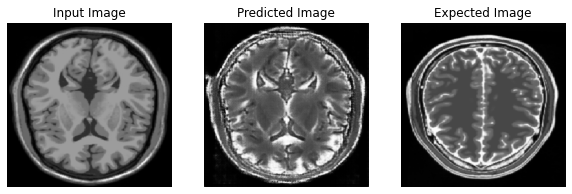

Saving checkpoint forepoch 0 at ./checkpoints/ckpt-11


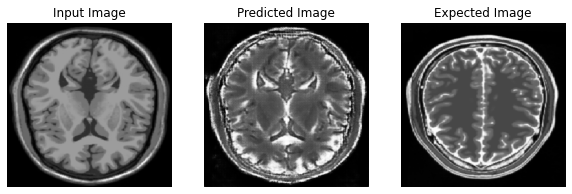

Saving checkpoint forepoch 1 at ./checkpoints/ckpt-12


In [101]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint forepoch', epoch, 'at', ckpt_save_path)

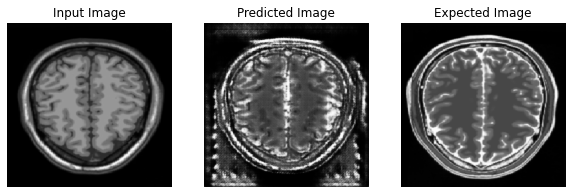

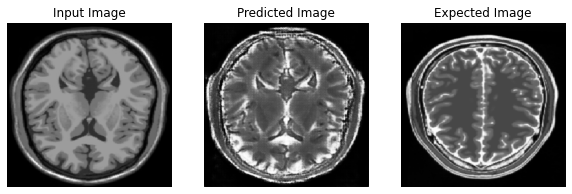

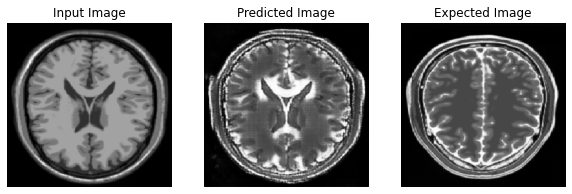

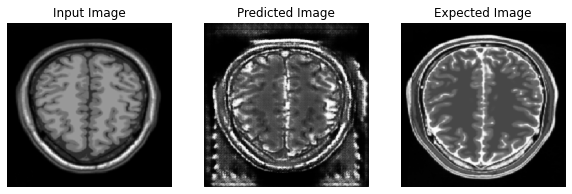

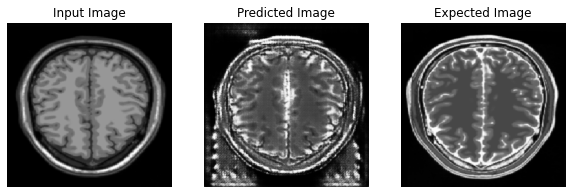

In [102]:
for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)

In [ ]:
#SOURCES:
#https://www.tensorflow.org/tutorials/generative/cyclegan
#https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py